In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from torch.nn import LSTM, Linear, Module, Softmax
from torch import tensor, optim
from tqdm.auto import tqdm

sns.set_style('whitegrid')

In [2]:
# Data retrieval.

start = '2006-03-01'
end = '2023-03-01'

indices = ['VTI', 'AGG', 'DBC', '^VIX']
prices = yf.download(indices, start=start, end=end)['Close'].dropna(axis=1)
returns = np.log(prices).diff()[1:]

[*********************100%***********************]  4 of 4 completed


In [3]:
# Aggregating the features (prices and returns).

features = pd.concat([prices.loc[returns.index], returns], axis=1)
features.head()

,AGG,DBC,VTI,^VIX,AGG,DBC,VTI,^VIX
Date,,,,,,,,
2006-03-02,99.699997,23.660000,64.305000,11.72,-0.002504,0.017911,-0.000700,0.015478
2006-03-03,99.500000,23.879999,64.199997,11.96,-0.002008,0.009255,-0.001634,0.020271
2006-03-06,98.949997,23.500000,63.730000,12.74,-0.005543,-0.016041,-0.007348,0.063179
2006-03-07,99.199997,23.090000,63.470001,12.66,0.002523,-0.017601,-0.004088,-0.006299
2006-03-08,99.250000,22.719999,63.650002,12.32,0.000504,-0.016154,0.002832,-0.027223


In [4]:
# Defining dimensions for input and target.

data  = features.copy()
seq_len = 50

n_assets = len(returns.columns)
n_samples = len(data[seq_len:])
n_features = len(data.columns)

print(f'''Number of Assets: {n_assets}
Number of Samples: {n_samples}
Number of features: {n_features} ({n_assets} assets x {n_features//n_assets} features)''')

Number of Assets: 4
Number of Samples: 4228
Number of features: 8 (4 assets x 2 features)


In [5]:
# Creating input array (3D).

input = np.zeros((n_samples, seq_len, n_features))
target = returns.iloc[seq_len:].values[:n_samples]

for i in range(n_samples):
    input[i] = features.iloc[i:(i + seq_len)].values

print(f'''Input shape: {input.shape}
Target shape: {target.shape}''')

Input shape: (4228, 50, 8)
Target shape: (4228, 4)


In [6]:
# Defining the model architecture.

class PortOptNN(Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PortOptNN, self).__init__()
        self.lstm = LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = Linear(hidden_dim, output_dim, bias=True)
        self.softmax = Softmax(dim=-1)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out_last = lstm_out[:, -1, :]
        fc_out = self.fc(lstm_out_last)
        output = self.softmax(fc_out)
        return output

In [7]:
# Defining objective function to optimize.
# l = E(R) / sqrt(E(R^2) - (ER)^2)

def objective(outputs, targets):
    portfolio_returns = (outputs * targets).sum(dim=1)
    mean_portfolio_return = portfolio_returns.mean() * 252
    mean_squared_portfolio_return = (portfolio_returns ** 2).mean() * (252 ** 2)
    denominator = torch.sqrt(mean_squared_portfolio_return - mean_portfolio_return ** 2)
    custom_objective_value = mean_portfolio_return / denominator
    return custom_objective_value

In [8]:
# Defining Model Parameters.

input_dim = input.shape[-1]
hidden_dim = 64
output_dim = target.shape[-1]

In [9]:
# Constants
train_pct = 0.9
epochs = 100
two_year_days = 252*2

# Function to split data
def get_data(start, end):
    return input[start:end], target[start:end]

# Define when testing starts (e.g., after five years)
test_start_day = 252 * 5

predicted_weights = []
model = PortOptNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), maximize=True)

# Loop through the entire dataset, including remaining days
for year_start in tqdm(range(0, len(input), two_year_days)):
    # Training and Validation (2006-2020)
    train_end = min(year_start + two_year_days, len(input))

    # Get training data up to the current period
    train_input, train_target = get_data(year_start, train_end)
    train_input_torch = torch.tensor(train_input, dtype=torch.float32)
    train_target_torch = torch.tensor(train_target, dtype=torch.float32)

    # Train the model
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_input_torch)
        gain = objective(outputs, train_target_torch)
        gain.backward()
        optimizer.step()
        if epoch+1 == epochs:
            s = features.index[year_start].year
            e = features.index[-len(features) + train_end].year
            print(f'({s}-{e}) {epoch+1}/{epochs}: Gain: {gain.item()}')

    # Predict the weights for the period from 2011-2020
    if year_start >= test_start_day:
        test_input, _ = get_data(year_start, train_end)
        test_input_torch = torch.tensor(test_input, dtype=torch.float32)

        # Predict and save the weights
        model.eval()
        with torch.no_grad():
            test_outputs = model(test_input_torch)
            predicted_weights.append(test_outputs)

  0%|          | 0/9 [00:00<?, ?it/s]

(2006-2008) 100/100: Gain: 0.21661776304244995
(2008-2010) 100/100: Gain: 0.1611461490392685
(2010-2012) 100/100: Gain: 0.24363553524017334
(2012-2014) 100/100: Gain: 0.2404244840145111
(2014-2016) 100/100: Gain: 0.25079312920570374
(2016-2018) 100/100: Gain: 0.2904766798019409
(2018-2020) 100/100: Gain: 0.23412422835826874
(2020-2022) 100/100: Gain: 0.3174728751182556
(2022-2022) 100/100: Gain: 0.14101018011569977


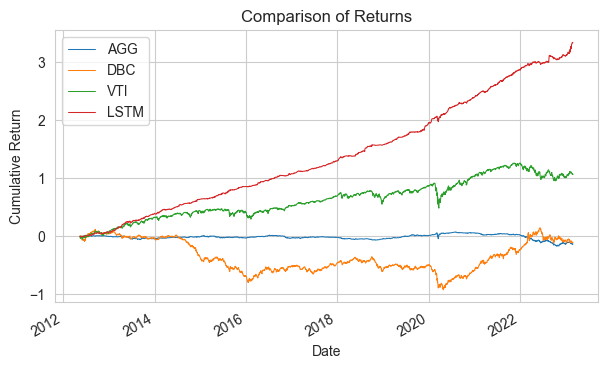

In [117]:
lstm_weights = pd.DataFrame(np.concatenate(predicted_weights), columns=returns.columns)
lstm_weights.index = returns.index[-len(lstm_weights):]
# lstm_weights = (lstm_weights / returns.rolling(seq_len).std().loc[lstm_weights.index])
# lstm_weights = (lstm_weights.T / lstm_weights.sum(axis=1)).T
lstm_returns = (returns.loc[lstm_weights.index] * lstm_weights).sum(axis=1)
costs = abs(lstm_weights.diff().sum(axis=1))
comparison = returns.loc[lstm_returns.index].copy()
comparison.iloc[0] = 0
comparison['LSTM'] = lstm_returns
comparison = comparison.drop(columns='^VIX')

growth = comparison.cumsum()
growth ['LSTM'] = growth['LSTM'] - costs.cumsum()
growth.plot(figsize=(7, 4), linewidth=.75)
plt.title('Comparison of Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

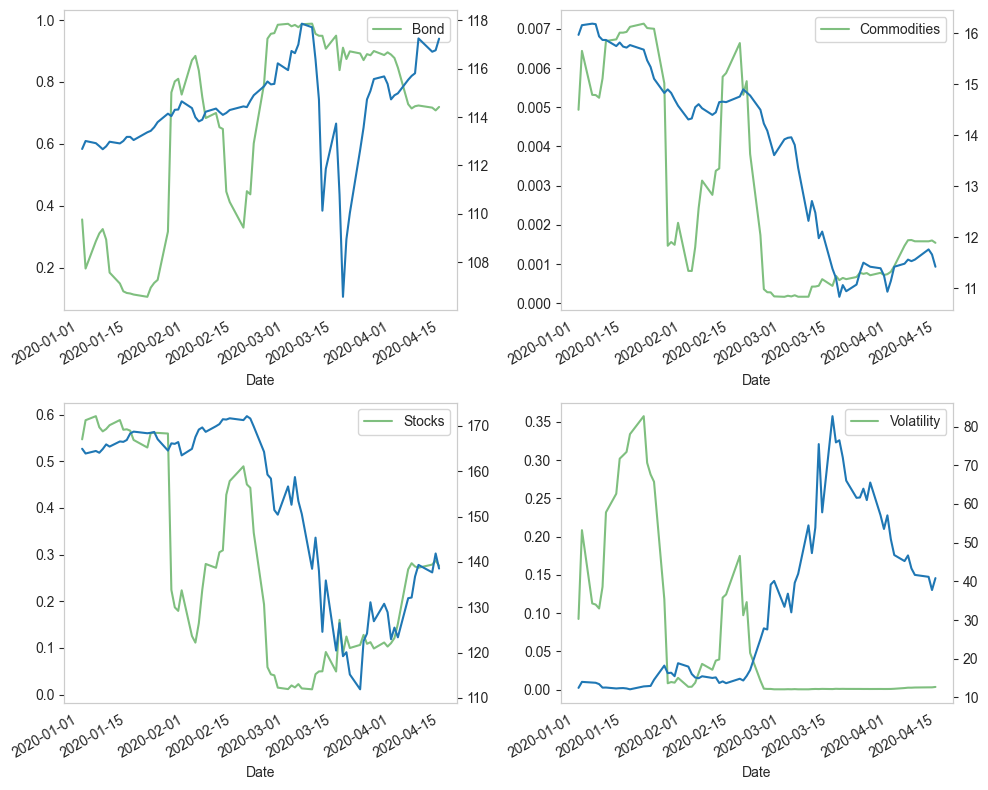

In [38]:
covid = lstm_weights.loc['2020-01':'2020-04-15']
covid_prices = prices.loc[covid.index]
assets = covid.columns.to_list()
categories = ['Bond', 'Commodities', 'Stocks', 'Volatility']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

ax00, ax01 = axes[0][0], axes[0][1]
ax10, ax11 = axes[1][0], axes[1][1]
all_axes = [ax00, ax01, ax10, ax11]

for i, ax in enumerate(all_axes):
    (covid[assets[i]]).plot(ax=ax, grid=False, color='g', alpha=.5)
    covid_prices[assets[i]].plot(ax=ax.twinx(), grid=False)
    ax.legend([categories[i]])

plt.tight_layout()

In [118]:
import trade_metrics.metrics as metrics

returns_dict = {col: comparison[col] for col in comparison}
stats = metrics.Metrics(returns_dict).calculate()
stats

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
AGG,-0.131989,-0.012246,0.046701,-0.690487,-0.219912
DBC,-0.102705,-0.009529,0.172710,-0.170976,-0.677003
VTI,1.063984,0.098720,0.176096,0.447030,-0.370847
LSTM,3.333606,0.309304,0.088262,3.277780,-0.091628
